In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dylanjcastillo/7k-books-with-metadata")

print("Path to dataset files:", path)

Path to dataset files: /home/sardor/.cache/kagglehub/datasets/dylanjcastillo/7k-books-with-metadata/versions/3


In [25]:
import pandas as pd
import numpy as np
import time
import requests

In [4]:
books = pd.read_csv(f"{path}/books.csv")

In [5]:
books.head(5)

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0
2,9780006163831,0006163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,3.97,479.0,172.0
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0


In [9]:
summary = books.describe(include="all").transpose()
summary["missing_values"] = books.isna().sum()
summary["non_missing_values"] = books.notna().sum()
summary

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,missing_values,non_missing_values
isbn13,6810.0,NaN,NaN,NaN,9780676621541.416016,606891056.586608,9780002005883.0,9780330341506.0,9780553108095.5,9780809982553.5,9789042003408.0,0,6810
isbn10,6810,6810,0002005883,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,6810
title,6810,6398,The Lord of the Rings,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,6810
subtitle,2381,2009,A Novel,226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4429,2381
authors,6738,3780,Agatha Christie,37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72,6738
categories,6711,567,Fiction,2588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99,6711
thumbnail,6481,6481,http://books.google.com/books/content?id=KQZCP...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,329,6481
description,6548,6474,No Marketing Blurb,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,262,6548
published_year,6804.0,NaN,NaN,NaN,1998.630364,10.484257,1853.0,1996.0,2002.0,2005.0,2019.0,6,6804
average_rating,6767.0,NaN,NaN,NaN,3.933284,0.331352,0.0,3.77,3.96,4.13,5.0,43,6767


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

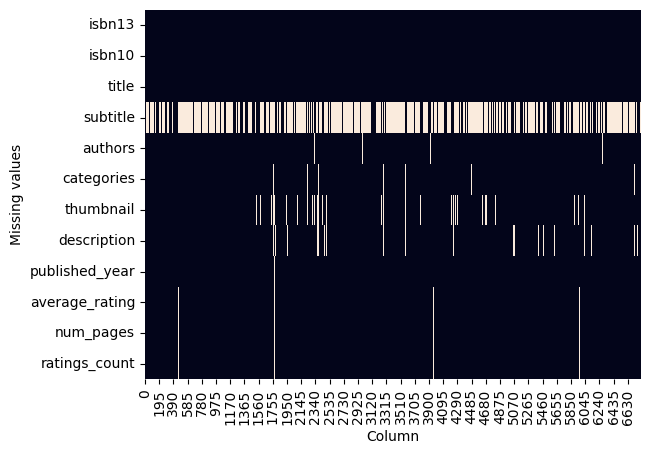

In [14]:
ax = plt.axes()
sns.heatmap(books.isna().transpose(), cbar=False, ax=ax)

plt.xlabel("Column")
plt.ylabel("Missing values")

plt.show()

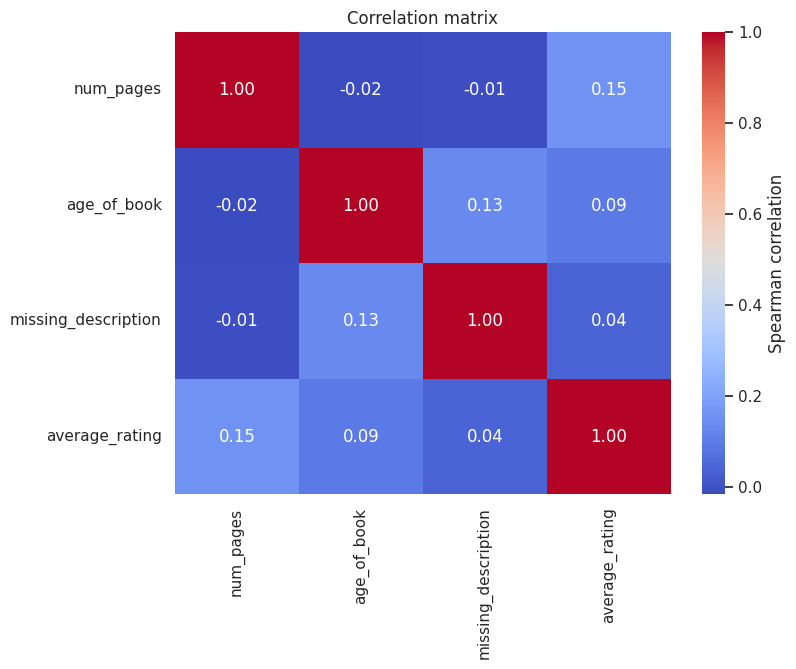

In [ ]:
books['missing_description'] = np.where(books['description'].isna(), 1, 0)
books['age_of_book'] = 2025 - books['published_year']

columns_of_interest = ["num_pages", "age_of_book", "missing_description", "average_rating"]
correlation_matrix = books[columns_of_interest].corr(method='spearman')

sns.set_theme(style='white')
plt.figure(figsize=(8,6))
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar_kws={'label': "Spearman correlation"})
heatmap.set_title("Correlation matrix")
plt.show()

Filling missing description for books

In [26]:
def fetch_description(isbn):
    url = f"https://www.googleapis.com/books/v1/volumes?q=isbn:{isbn}"
    try:
        response = requests.get(url, timeout=5)
        data = response.json()
        items = data.get("items")
        if items:
            volume_info = items[0].get("volumeInfo", {})
            return volume_info.get("description")
    except Exception as e:
        print(f"Error fetching ISBN {isbn}: {e}")
    return None


for i, row in books[books['description'].isna()].iterrows():
    isbn = row['isbn10']
    title = row['title']
    desc = fetch_description(isbn)
    if desc:
        books.at[i, 'description'] = desc
        print(f"Filled description for ISBN {isbn} and title {title}")
    else:
        print(f"No description found for ISBN {isbn} and title {title}")
    time.sleep(0.1)  

No description found for ISBN 000690601X and title The Princess of the Chalet School
Filled description for ISBN 000712774X and title The illustrated man
No description found for ISBN 0020442807 and title The Chronicles of Narnia: Lion, the witch and the wardrobe
Filled description for ISBN 0023513209 and title Reason in History
No description found for ISBN 0026995018 and title Spandau
No description found for ISBN 006440546X and title Betsy and Joe
Filled description for ISBN 007325035X and title Heat and Mass Transfer
No description found for ISBN 0091520800 and title My Sweet-orange Tree
No description found for ISBN 0140042326 and title The Pearl
Filled description for ISBN 0140059024 and title Wodehouse on crime
No description found for ISBN 0140093141 and title I, Claudius and Claudius the God
Filled description for ISBN 0140097317 and title The New York Trilogy
No description found for ISBN 014013798X and title Case Histories I
Filled description for ISBN 0140153179 and title A

In [28]:
books.isna().sum()

isbn13                    0
isbn10                    0
title                     0
subtitle               4429
authors                  72
categories               99
thumbnail               329
description             162
published_year            6
average_rating           43
num_pages                43
ratings_count            43
missing_description       0
age_of_book               6
dtype: int64

In [42]:
books_missing = books[books['description'].isna() |
      books['num_pages'].isna() |
      books['average_rating'].isna() |
      books['published_year'].isna() 
] 

books = books[~books['isbn10'].isin(books_missing['isbn10'])]

In [48]:
books.isna().sum()

isbn13                    0
isbn10                    0
title                     0
subtitle               4290
authors                  67
categories               55
thumbnail               252
description               0
published_year            0
average_rating            0
num_pages                 0
ratings_count             0
missing_description       0
age_of_book               0
dtype: int64

Category of the book

In [52]:
books['categories'].value_counts().reset_index().sort_values("count", ascending=False)

,categories,count
0,Fiction,2545
1,Juvenile Fiction,534
2,Biography & Autobiography,395
3,History,259
4,Literary Criticism,165
...,...,...
539,Animal sanctuaries,1
540,"Adventure stories, English",1
541,Germany,1
542,Actresses,1


Number of words in description

In [53]:
books["words_in_desc"] = books['description'].str.split().str.len()

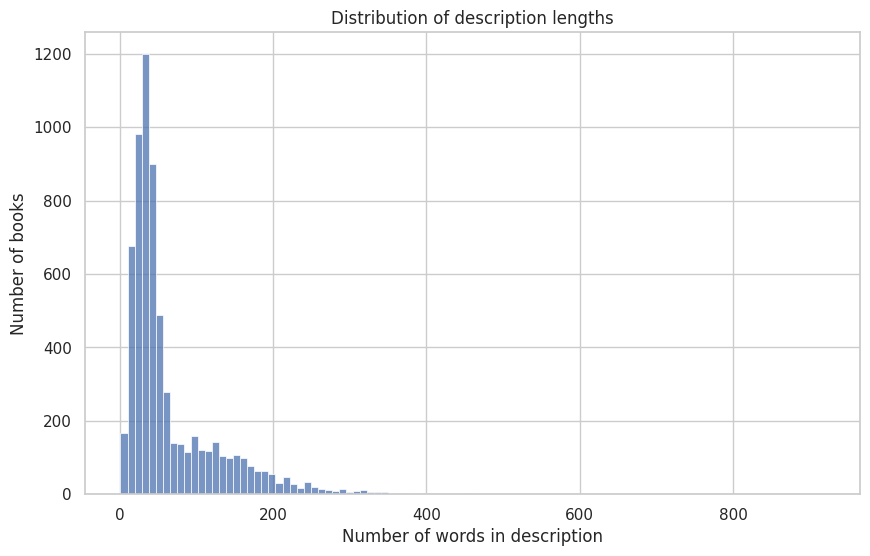

In [58]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10,6))

sns.histplot(books['words_in_desc'], bins=100)
plt.xlabel("Number of words in description")
plt.ylabel("Number of books")
plt.title("Distribution of description lengths")
plt.show()


In [60]:
books.loc[books['words_in_desc'].between(1, 4), "description"]

6                                           Donation.
11                                     Fantasy-roman.
748              Includes bibliographical references.
770                             Bound For Oregon (PB)
775                                No Marketing Blurb
812                                No Marketing Blurb
857                          First published in 1813.
944                         Edited by Maurice Hindle.
953                        DEFOE/ROBINSON CRUSOE (BC)
954                             Edited by John Carey.
962                         ALLEN/GETTING THINGS DONE
1054                            GILBERT/EAT PRAY LOVE
1056    "Graham Greene centennial, 1904-2004"--Cover.
1060                   STEINBECK/GRAPES OF WRATH (BC)
1346                                   Fantasy-roman.
1546                                      Winter 2003
1610                                      Winter 1999
1813                             National bestseller.
1966        "Silhouette spec

In [61]:
books.loc[books['words_in_desc'].between(5, 14), "description"]

2       Volume Two of Stephen Donaldson's acclaimed se...
38      Koko is Peter Straub's foray into the psycholo...
60        First pub. 1951. Sci-fi/fantasy/horror stories.
70      A matter of life and death - and the Throne of...
77                         Nonsense rhyming story. 4 yrs+
                              ...                        
6715    The first comprehensive guide to addressing Na...
6726       Presents two complete novels from Henry James.
6757                          Audio Book- unabriged on CD
6776    Raymond Chandler meets The Exorcist. Classic n...
6795    Book Of Five Rings is a Kodansha International...
Name: description, Length: 319, dtype: object

In [62]:
books.loc[books['words_in_desc'].between(15, 24), "description"]

10      One of Sidney Sheldon's most popular and bests...
32      Tells the story of three generations of Chines...
36      A magical and fantastic collection of early st...
57      A young drifter finds more than he bargained f...
68      A new 'The Doors of Perception' for the 21st c...
                              ...                        
6767    Everything from the fingerprints of the gods t...
6782    Displays one of America's leading physicist's ...
6783    Basics Illustration 01: Thinking Visually expl...
6789    Provides an introduction to the American artis...
6809    This is a jubilant and rewarding collection of...
Name: description, Length: 968, dtype: object

In [63]:
books.loc[books['words_in_desc'].between(25, 34), "description"]

9       Kate Blackwell is an enigma and one of the mos...
14      Available in the U.S. for the first time, this...
20      It is 1937, and Charles Ashworth, a Canon to t...
21      Reissue of the author's most famous and well-l...
46      No one believes a little girl when she insists...
                              ...                        
6760    Joel, an English teacher, has never really lik...
6766    Discusses the historical and intellectual back...
6775    Presents nearly one thousand recipes--from app...
6779    Edited by the creator and executive producer o...
6799    This book is the story of a young girl obsesse...
Name: description, Length: 1241, dtype: object

In [64]:
books = books[books['words_in_desc'] >= 25]

In [65]:
len(books)

5260

Merging title and subtitle

In [66]:
books["title_and_subtitle"] = (np.where(books["subtitle"].isna(), books["title"], books[['title', 'subtitle']].astype(str).agg(": ".join, axis=1)))

/tmp/ipykernel_40855/3548307281.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books["title_and_subtitle"] = (np.where(books["subtitle"].isna(), books["title"], books[['title', 'subtitle']].astype(str).agg(": ".join, axis=1)))


In [67]:
books

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description,age_of_book,words_in_desc,title_and_subtitle
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,0,21.0,199,Gilead
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,0,25.0,205,Spider's Web: A Novel
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,0,32.0,57,Rage of angels
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,0,23.0,45,The Four Loves
5,9780006280934,0006280935,The Problem of Pain,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,0,23.0,75,The Problem of Pain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6802,9788172235222,8172235224,Mistaken Identity,NaN,Nayantara Sahgal,Indic fiction (English),http://books.google.com/books/content?id=q-tKP...,On A Train Journey Home To North India After L...,2003.0,2.93,324.0,0.0,0,22.0,288,Mistaken Identity
6803,9788173031014,8173031010,Journey to the East,NaN,Hermann Hesse,Adventure stories,http://books.google.com/books/content?id=rq6JP...,This book tells the tale of a man who goes on ...,2002.0,3.70,175.0,24.0,0,23.0,63,Journey to the East
6804,9788179921623,817992162X,The Monk Who Sold His Ferrari: A Fable About F...,NaN,Robin Sharma,Health & Fitness,http://books.google.com/books/content?id=c_7mf...,"Wisdom to Create a Life of Passion, Purpose, a...",2003.0,3.82,198.0,1568.0,0,22.0,117,The Monk Who Sold His Ferrari: A Fable About F...
6805,9788185300535,8185300534,I Am that,Talks with Sri Nisargadatta Maharaj,Sri Nisargadatta Maharaj;Sudhakar S. Dikshit,Philosophy,http://books.google.com/books/content?id=Fv_JP...,This collection of the timeless teachings of o...,1999.0,4.51,531.0,104.0,0,26.0,174,I Am that: Talks with Sri Nisargadatta Maharaj


Tagged description

In [68]:
books['tagged_description'] = books[['isbn13', 'description']].astype(str).agg(" ".join, axis=1)

/tmp/ipykernel_40855/149327456.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books['tagged_description'] = books[['isbn13', 'description']].astype(str).agg(" ".join, axis=1)


In [69]:
books

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description,age_of_book,words_in_desc,title_and_subtitle,tagged_description
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,0,21.0,199,Gilead,9780002005883 A NOVEL THAT READERS and critics...
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,0,25.0,205,Spider's Web: A Novel,9780002261982 A new 'Christie for Christmas' -...
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,0,32.0,57,Rage of angels,"9780006178736 A memorable, mesmerizing heroine..."
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,0,23.0,45,The Four Loves,9780006280897 Lewis' work on the nature of lov...
5,9780006280934,0006280935,The Problem of Pain,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,0,23.0,75,The Problem of Pain,"9780006280934 ""In The Problem of Pain, C.S. Le..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6802,9788172235222,8172235224,Mistaken Identity,NaN,Nayantara Sahgal,Indic fiction (English),http://books.google.com/books/content?id=q-tKP...,On A Train Journey Home To North India After L...,2003.0,2.93,324.0,0.0,0,22.0,288,Mistaken Identity,9788172235222 On A Train Journey Home To North...
6803,9788173031014,8173031010,Journey to the East,NaN,Hermann Hesse,Adventure stories,http://books.google.com/books/content?id=rq6JP...,This book tells the tale of a man who goes on ...,2002.0,3.70,175.0,24.0,0,23.0,63,Journey to the East,9788173031014 This book tells the tale of a ma...
6804,9788179921623,817992162X,The Monk Who Sold His Ferrari: A Fable About F...,NaN,Robin Sharma,Health & Fitness,http://books.google.com/books/content?id=c_7mf...,"Wisdom to Create a Life of Passion, Purpose, a...",2003.0,3.82,198.0,1568.0,0,22.0,117,The Monk Who Sold His Ferrari: A Fable About F...,9788179921623 Wisdom to Create a Life of Passi...
6805,9788185300535,8185300534,I Am that,Talks with Sri Nisargadatta Maharaj,Sri Nisargadatta Maharaj;Sudhakar S. Dikshit,Philosophy,http://books.google.com/books/content?id=Fv_JP...,This collection of the timeless teachings of o...,1999.0,4.51,531.0,104.0,0,26.0,174,I Am that: Talks with Sri Nisargadatta Maharaj,9788185300535 This collection of the timeless ...


Dropping some columns

In [71]:
books.drop(['subtitle', 'missing_description', "age_of_book", "words_in_desc"], axis=1).to_csv("books_cleaned.csv", index=False)